In [2]:
import seaborn as sns
import pandas as pd
from ctgan import CTGAN
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [4]:
wallets_features = pd.read_csv("../dataset/custom/train_test_split/wallets_features_aggregated__train.csv")
wallets_features.head()

,class,num_timesteps_appeared_in,fees_median,num_addr_transacted_multiple,addrId,userId,user_ts_fees_share_mean,user_ts_fees_share_min,user_ts_fees_share_max,user_addr_cnt,...,btc_sent_min,btc_received_min,fees_min,transacted_w_address_min,btc_transacted_max,btc_sent_max,btc_received_max,fees_max,last_block_appeared_in,transacted_w_address_max
0,1,1.0,0.000037,0.0,1LUwMvFBLBpofVFmFpZE6GLu2Bt6dmE9t3,509812,0.101106,0.101106,0.101106,1,...,0.00000,0.0,0.000037,1.0,0.17695,0.07725,0.17695,0.000217,433546.0,1.0
1,1,1.0,0.000040,0.0,17fuBJ5qquYF6VTX8n19t9yccp95vWEVME,331400,0.194991,0.194991,0.194991,4,...,0.00026,0.0,0.000040,1.0,0.00026,0.00026,0.00000,0.000040,395236.0,1.0
2,1,1.0,0.000040,0.0,1CQ77ewS2smh8aBP3pahuVEt67ga3YWvL9,331400,0.194991,0.194991,0.194991,4,...,0.00200,0.0,0.000040,1.0,0.00200,0.00200,0.00000,0.000040,395236.0,1.0
3,1,1.0,0.000040,0.0,1EhTXo5svU9SJvk6ZvmKnFQwVDo6a5tKH2,331400,0.194991,0.194991,0.194991,4,...,0.00220,0.0,0.000040,1.0,0.00220,0.00220,0.00000,0.000040,395236.0,1.0
4,1,1.0,0.000040,0.0,1GP4t8rAiZJ7wAcYZLL8f5sm9vdvUU9tUu,331400,0.194991,0.194991,0.194991,4,...,0.00178,0.0,0.000040,1.0,0.00178,0.00178,0.00000,0.000040,395236.0,1.0


In [5]:

import warnings

import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional
from tqdm import tqdm

from ctgan.data_sampler import DataSampler
from ctgan.data_transformer import DataTransformer
from ctgan.errors import InvalidDataError
from ctgan.synthesizers.base import BaseSynthesizer, random_state


class Discriminator(Module):
    """Discriminator for the CTGAN."""

    def __init__(self, input_dim, discriminator_dim, pac=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim
        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(0.5)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):
        """Compute the gradient penalty."""
        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients_view = gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        gradient_penalty = ((gradients_view) ** 2).mean() * lambda_

        return gradient_penalty

    def forward(self, input_):
        """Apply the Discriminator to the `input_`."""
        assert input_.size()[0] % self.pac == 0
        return self.seq(input_.view(-1, self.pacdim))


class Residual(Module):
    """Residual layer for the CTGAN."""

    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input_):
        """Apply the Residual layer to the `input_`."""
        out = self.fc(input_)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input_], dim=1)


class Generator(Module):
    """Generator for the CTGAN."""

    def __init__(self, embedding_dim, generator_dim, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(generator_dim):
            seq += [Residual(dim, item)]
            dim += item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input_):
        """Apply the Generator to the `input_`."""
        data = self.seq(input_)
        return data


In [6]:
wallets_features.columns

Index(['class', 'num_timesteps_appeared_in', 'fees_median',
       'num_addr_transacted_multiple', 'addrId', 'userId',
       'user_ts_fees_share_mean', 'user_ts_fees_share_min',
       'user_ts_fees_share_max', 'user_addr_cnt', 'user_outcoming_tx_cnt',
       'user_incoming_tx_cnt', 'user_input_users_cnt', 'user_output_users_cnt',
       'user_active_time_steps_cnt', 'user_btc_sent_total',
       'user_btc_received_total', 'user_interracted_output_address_cnt',
       'user_interracted_input_address_cnt', 'user_overall_activity_coef',
       'user_whole_fee_5', 'addr_gini', 'whole_fees_5', 'num_txs_as_sender',
       'num_txs_as receiver', 'lifetime_in_blocks', 'total_txs',
       'btc_transacted_total', 'btc_sent_total', 'btc_received_total',
       'fees_total', 'transacted_w_address_total', 'first_block_appeared_in',
       'first_sent_block', 'first_received_block', 'btc_transacted_min',
       'btc_sent_min', 'btc_received_min', 'fees_min',
       'transacted_w_address_min', 'btc

In [7]:
def prepare_wallets_features_for_gan(df):
    return df \
        .drop([
            "class", "addrId", "userId",
            'user_ts_fees_share_mean', 'user_ts_fees_share_min',
            'user_ts_fees_share_max', 'user_addr_cnt', 'user_outcoming_tx_cnt',
            'user_incoming_tx_cnt', 'user_input_users_cnt', 'user_output_users_cnt',
            'user_active_time_steps_cnt', 'user_btc_sent_total',
            'user_btc_received_total', 'user_interracted_output_address_cnt',
            'user_interracted_input_address_cnt', 'user_overall_activity_coef',
            'user_whole_fee_5', "last_block_appeared_in"
        ], axis=1)

In [8]:
wallets_features_licit = wallets_features[wallets_features["class"] == 2]
wallets_features_illicit = wallets_features[wallets_features["class"] == 1]

wallets_features_licit.shape, wallets_features_illicit.shape

((81867, 46), (10067, 46))

In [9]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit_transform(prepare_wallets_features_for_gan(wallets_features_licit))

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.65384615, 0.00167647, 0.00248447, ..., 0.02654109, 0.00671321,
        0.04444444],
       [0.69230769, 0.00167647, 0.00434783, ..., 0.05061988, 0.02027754,
        0.02222222],
       [1.        , 0.00205189, 0.14347826, ..., 0.40119308, 0.58197086,
        0.15555556]])

In [10]:
# ctgan = CTGAN(
#     epochs=100,
#     verbose=True,
#     embedding_dim=256,
#     generator_dim=(256, 512, 256),
# )
# ctgan.fit(
#     prepare_wallets_features_for_gan(wallets_features_licit),
# )


In [11]:
# torch.save(ctgan, "./ctgan_wallets_300.pth")
ctgan = torch.load("./model.pth", map_location=torch.device('cpu'))

In [12]:
ctgan._generator

Generator(
  (seq): Sequential(
    (0): Residual(
      (fc): Linear(in_features=512, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Residual(
      (fc): Linear(in_features=768, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): Residual(
      (fc): Linear(in_features=1280, out_features=1024, bias=True)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): Residual(
      (fc): Linear(in_features=2304, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (4): Residual(
      (fc): Linear(in_features=2816, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=Tr

In [13]:
import torch.nn.functional as F


def detect_anomaly(vec, vec_df):
    ctgan._generator.eval()
    ctgan._discriminator.eval()

    mean = torch.zeros(2, ctgan._embedding_dim)
    std = mean + 1
    z = torch.normal(mean=mean, std=std).to(ctgan._device)
    z.requires_grad = True
    optimizer = torch.optim.Adam([z], lr=1 * 1e-2)

    features_real = {}
    features_fake = {}

    feats_hist = []

    def hook_real(module, input, output):
        features_real['feat'] = output
        feats_hist.append(output)

    def hook_fake(module, input, output):
        features_fake['feat'] = output
        feats_hist.append(output)

    layer = list(list(ctgan._discriminator.children())[0].children())[-3]  # adjust depending on your D architecture
    handle_real = layer.register_forward_hook(hook_real)

    vec_transformed = ctgan._transformer.transform(vec_df)

    vec_transformed_vectorized = torch.cat([
        torch.tensor([vec_transformed]),
    ]*10)
    vec_transformed_vectorized_single = torch.tensor(vec_transformed[0,:])


    res_losses_hist = []
    loss_hist = []

    STEPS = 100
    for i in range(STEPS):
        optimizer.zero_grad()

        fake = ctgan._generator(z)

        fakeact = ctgan._apply_activate(fake)

        fake_vectorized = torch.cat([
            torch.tensor(fakeact),
        ]*10)


        ctgan._discriminator(vec_transformed_vectorized.type(torch.float))

        ctgan._discriminator(fake_vectorized.type(torch.float))
    
        feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
        
        residual_loss = F.l1_loss(fake[0,:], vec_transformed_vectorized_single)


        loss = residual_loss + 0.1 * feature_loss

        loss.backward()
        optimizer.step()

        feats_hist = []

        # print(loss)
        loss_hist.append(loss.item())

        # print(z[1,:10])

    return loss_hist[-1], loss_hist


In [14]:
# prepared_wallets_data_illicit.shape, prepared_wallets_data.shape

In [15]:
prepared_wallets_data = prepare_wallets_features_for_gan(wallets_features_licit).reset_index().drop(columns=["index"])
prepared_wallets_data_illicit = prepare_wallets_features_for_gan(wallets_features_illicit).reset_index().drop(columns=["index"])

licit_scores = []
illicit_scores = []

for i in range(10):
    score, _ = detect_anomaly(
        np.array(prepared_wallets_data)[i,:],
        prepared_wallets_data.iloc[i:i+2,:]
    )
    licit_scores.append(score)

    score_illicit, _ = detect_anomaly(
        np.array(prepared_wallets_data_illicit)[i,:],
        prepared_wallets_data_illicit.iloc[i:i+1,:]
    )
    illicit_scores.append(score_illicit)

    print(f"licit: {score}, illicit: {score_illicit}")

licit: 1.3904637279099399, illicit: 1.3221797498117438


KeyboardInterrupt: 

In [16]:
import concurrent.futures
import time

licit_scores = []
illicit_scores = []

BS = 100

def processing_func_0():
    ID = 0
    for i in range(BS * ID, BS * (ID + 1)):
        score, _ = detect_anomaly(
            np.array(prepared_wallets_data)[i,:],
            prepared_wallets_data.iloc[i:i+1,:]
        )
        licit_scores.append(score)

        score_illicit, _ = detect_anomaly(
            np.array(prepared_wallets_data_illicit)[i,:],
            prepared_wallets_data_illicit.iloc[i:i+1,:]
        )
        illicit_scores.append(score_illicit)
        if i % 40 == 0:
            print(f"Thread {ID}: licit: {score}, illicit: {score_illicit}")
    return

def processing_func_1():
    ID = 1
    for i in range(BS * ID, BS * (ID + 1)):
        score, _ = detect_anomaly(
            np.array(prepared_wallets_data)[i,:],
            prepared_wallets_data.iloc[i:i+1,:]
        )
        licit_scores.append(score)

        score_illicit, _ = detect_anomaly(
            np.array(prepared_wallets_data_illicit)[i,:],
            prepared_wallets_data_illicit.iloc[i:i+1,:]
        )
        illicit_scores.append(score_illicit)
        if i % 40 == 0:
            print(f"Thread {ID}: licit: {score}, illicit: {score_illicit}")
    return

def processing_func_2():
    ID = 2
    for i in range(BS * ID, BS * (ID + 1)):
        score, _ = detect_anomaly(
            np.array(prepared_wallets_data)[i,:],
            prepared_wallets_data.iloc[i:i+1,:]
        )
        licit_scores.append(score)

        score_illicit, _ = detect_anomaly(
            np.array(prepared_wallets_data_illicit)[i,:],
            prepared_wallets_data_illicit.iloc[i:i+1,:]
        )
        illicit_scores.append(score_illicit)
        if i % 40 == 0:
            print(f"Thread {ID}: licit: {score}, illicit: {score_illicit}")
    return

def processing_func_3():
    ID = 3
    for i in range(BS * ID, BS * (ID + 1)):
        score, _ = detect_anomaly(
            np.array(prepared_wallets_data)[i,:],
            prepared_wallets_data.iloc[i:i+1,:]
        )
        licit_scores.append(score)

        score_illicit, _ = detect_anomaly(
            np.array(prepared_wallets_data_illicit)[i,:],
            prepared_wallets_data_illicit.iloc[i:i+1,:]
        )
        illicit_scores.append(score_illicit)
        if i % 40 == 0:
            print(f"Thread {ID}: licit: {score}, illicit: {score_illicit}")
    return

def processing_func_4():
    ID = 4
    for i in range(BS * ID, BS * (ID + 1)):
        score, _ = detect_anomaly(
            np.array(prepared_wallets_data)[i,:],
            prepared_wallets_data.iloc[i:i+1,:]
        )
        licit_scores.append(score)

        score_illicit, _ = detect_anomaly(
            np.array(prepared_wallets_data_illicit)[i,:],
            prepared_wallets_data_illicit.iloc[i:i+1,:]
        )
        illicit_scores.append(score_illicit)
        if i % 40 == 0:
            print(f"Thread {ID}: licit: {score}, illicit: {score_illicit}")
    return

with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(processing_func_0)
    future2 = executor.submit(processing_func_1)
    future3 = executor.submit(processing_func_2)
    future4 = executor.submit(processing_func_3)
    future5 = executor.submit(processing_func_4)

    result1 = future1.result()  # Get return value of func1
    result2 = future2.result()
    result3 = future3.result()
    result4 = future4.result()
    result5 = future5.result()
# processing_func_0()

Thread 0: licit: 1.342763637442018, illicit: 1.0331462561434175
Thread 0: licit: 1.4419425664391552, illicit: 1.2816669278860926
Thread 0: licit: 1.054054241818629, illicit: 1.2690899327159175


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [52]:
licit_scores

[1.72986405197183,
 1.668764539557085,
 1.4762777565783318,
 1.3275799923105327,
 1.7252559424254768,
 1.6624264976007206,
 1.4717419374618477,
 2.115038208140466,
 1.7070401791709826,
 1.5719449548807893]

<Axes: >

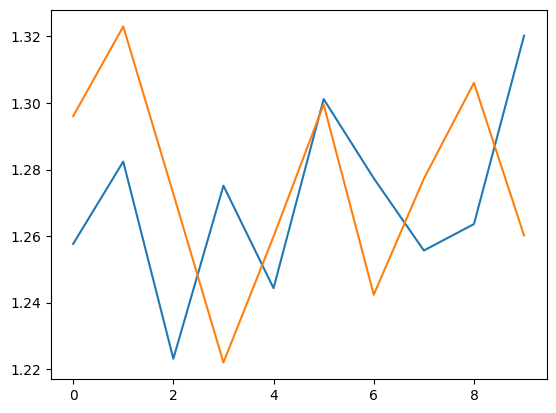

In [58]:
sns.lineplot(licit_scores)
sns.lineplot(illicit_scores)


In [49]:
licit_scores

[1.3188931825465435,
 1.451430539968899,
 1.3614806835927196,
 1.33177850430604,
 1.3981289874554954,
 1.499089222767242,
 1.4229676614319566,
 1.369374338101073,
 1.323741513021462,
 1.2878388777366034]

In [50]:
illicit_scores

[1.3411379238633168,
 1.3863375891523027,
 1.3972368180480585,
 1.338905668560667,
 1.3227125532609014,
 1.3645110058010277,
 1.38093001654687,
 1.5135586193307207,
 1.3819829011613531,
 1.3759380126712866]

In [30]:
# pd.DataFrame(prepared_wallets_data.iloc[0])
prepared_wallets_data.iloc[0:1,:]

,num_timesteps_appeared_in,fees_median,num_addr_transacted_multiple,addr_gini,whole_fees_5,num_txs_as_sender,num_txs_as receiver,lifetime_in_blocks,total_txs,btc_transacted_total,...,btc_sent_min,btc_received_min,fees_min,transacted_w_address_min,btc_transacted_max,btc_sent_max,btc_received_max,fees_max,last_block_appeared_in,transacted_w_address_max
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.001,...,0.001,0.0,0.0,1.0,0.001,0.001,0.0,0.0,391200.0,1.0


<Axes: ylabel='Generator Loss'>

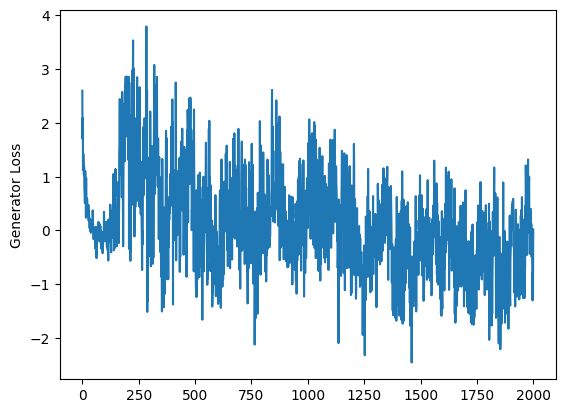

In [17]:
sns.lineplot(ctgan.loss_values["Generator Loss"])


<Axes: ylabel='Discriminator Loss'>

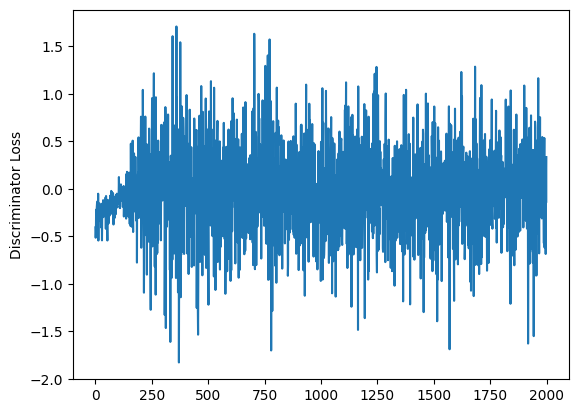

In [18]:
sns.lineplot(ctgan.loss_values["Discriminator Loss"])

In [65]:
ctgan.sample(10)

,num_timesteps_appeared_in,fees_median,num_addr_transacted_multiple,addr_gini,whole_fees_5,num_txs_as_sender,num_txs_as receiver,lifetime_in_blocks,total_txs,btc_transacted_total,...,btc_sent_min,btc_received_min,fees_min,transacted_w_address_min,btc_transacted_max,btc_sent_max,btc_received_max,fees_max,last_block_appeared_in,transacted_w_address_max
0,0.999765,0.002023,-0.001090,0.000335,-0.000349,-3.904722,2.766483,-238.036671,19.675304,83.554483,...,-0.053617,-0.006511,0.002173,1.000309,0.103342,0.013532,0.030626,0.001574,453476.833088,1.001445
1,0.999980,0.002882,0.000591,0.000307,0.998506,7.906769,0.610675,-899.838286,-7.361904,-0.749674,...,0.355678,-0.006639,0.001007,0.999726,0.645316,0.867760,0.317114,0.002814,460843.624838,1.000593
2,0.999293,0.090221,-0.018055,0.000311,0.000750,19.325858,1.857647,-854.438794,16.227356,-9.704921,...,-0.045286,-0.009880,0.090552,0.999994,1.117854,0.715809,0.284030,0.090441,467611.291753,1.002265
3,0.999098,0.010832,-0.017875,0.000380,0.000960,-1.621824,0.270334,-118.674395,0.097085,12.059220,...,-0.012180,0.001331,0.023539,1.000042,0.034795,0.000539,0.013087,0.021668,463068.623432,1.000550
4,1.000244,-0.000762,-0.000738,-0.000231,-0.001792,-5.577079,3.379736,145.691309,-4.995278,47.404585,...,0.004326,-0.001510,0.001867,0.999853,3.707871,0.095239,4.355315,0.002087,395006.483764,0.999461
5,1.000072,0.003257,-0.006286,-0.000161,0.000211,10.945082,-0.229185,167.142562,3.511022,5.101578,...,-0.020074,-0.005102,0.003762,0.999894,0.049571,-0.006257,-0.014769,0.002511,461014.109899,1.002247
6,1.000390,0.002389,0.002537,0.000013,0.000959,0.503370,0.153633,-167.863429,-4.289312,50.002216,...,0.358035,-0.001261,0.002791,1.000039,3.393426,2.679947,-0.009320,0.001770,430149.594037,1.000446
7,0.998901,0.000844,-0.001202,-0.000053,-0.000521,-2.237193,2.791758,81.126560,11.165466,41.448352,...,-0.063318,-0.006865,0.001092,1.000017,0.117666,30.045457,15.136612,0.000794,450678.348770,1.001274
8,1.000180,0.026806,-0.011752,-0.000072,0.000418,8.392089,0.456691,-45.238601,-1.618460,38.292553,...,0.014886,-0.001147,0.010883,0.999756,0.101202,0.081381,0.018701,0.007474,463289.547361,1.000630
9,1.000787,0.006737,-0.000826,0.000144,0.000343,-6.430670,-0.040499,-189.914427,-10.396301,19.788046,...,0.061420,-0.005911,0.002022,1.000219,4.163338,0.006704,0.016985,0.000961,450489.582660,0.999145


<Axes: >

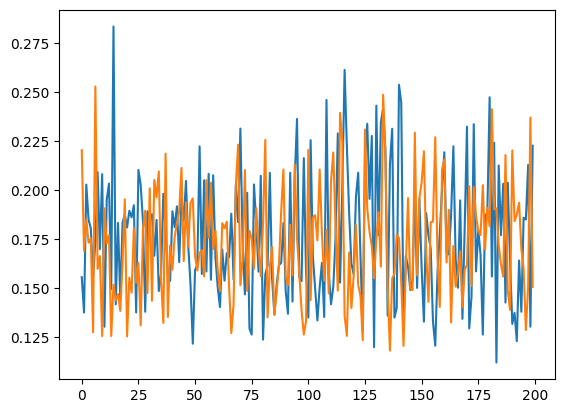

In [ ]:
sns.lineplot(
)
sns.lineplot(

)

In [78]:
licit_scores = np.array([0.15561598939711907, 0.13756289022647344, 0.20288023191209986, 0.18494768783287263, 0.18047135492629934, 0.1554361817106365, 0.1739043699488011, 0.20925816363722138, 0.16992708930737283, 0.2081954127025977, 0.13029874281556536, 0.19502594768002432, 0.20339358925273138, 0.14961322569541807, 0.28360054352118164, 0.14178657419308244, 0.1832901590612327, 0.14441413589211052, 0.18340566047539725, 0.18750435304476762, 0.18098137114084306, 0.18951178007785757, 0.18615045775404312, 0.19232348113019004, 0.1375821685919515, 0.21035989171403802, 0.2027354199532721, 0.18433700902207353, 0.13795954948924632, 0.18921232862349757, 0.18440611193627518, 0.18776787358650687, 0.1665379635807701, 0.1848635294749018, 0.1485411996065213, 0.15732509166290803, 0.19820250156994476, 0.17925090988338588, 0.1555204630278788, 0.1537036322315014, 0.18925963250292088, 0.18115367386018472, 0.1918003254908464, 0.1633022293198726, 0.1958757422905097, 0.18446207491653266, 0.2047558377206891, 0.17162443430774244, 0.15165188349484332, 0.12163840571934662, 0.1592176512789856, 0.16208920340534555, 0.22240133203310336, 0.1572407098560984, 0.20510176148896186, 0.1585070712031218, 0.20838694439528604, 0.15428249802021077, 0.20762387801274118, 0.16564958954133124, 0.1505287740960933, 0.1403420875369275, 0.16980746630010107, 0.1538062164610934, 0.16786512567479162, 0.16575194969732435, 0.188002961134961, 0.15434570770829104, 0.2027111694151078, 0.18371560562379263, 0.23149170229911725, 0.1721301790222078, 0.14680909691680868, 0.19868537113575313, 0.12948542786418055, 0.12632159720966718, 0.20296354711722048, 0.18303656693883896, 0.15846474239661668, 0.20733979569819494, 0.1237371518222002, 0.15710277403140493, 0.16143776715021418, 0.2088783738886823, 0.15481834494427546, 0.13672341335331575, 0.15169761227835224, 0.16170067986181044, 0.16299845991218198, 0.18325279859091914, 0.14867091789182763, 0.13693672806370774, 0.20894062450549747, 0.14315850562373267, 0.20633480098384296, 0.23641361080552517, 0.15568602670755266, 0.15358822775973496, 0.21639802391255245, 0.1571434046989661, 0.1350208213235302, 0.22556324254474436, 0.1660888721254115, 0.1501754833912465, 0.13354363165463173, 0.15068802149900556, 0.16293297200746043, 0.13528804442990042, 0.24607865860589462, 0.1584802241576117, 0.14176346536256146, 0.15064790861299235, 0.17602530569920652, 0.22905803984304948, 0.15284429577539949, 0.2024781589163143, 0.2614263177046658, 0.2224091785240569, 0.18834003928666082, 0.16235518140255822, 0.15705762578985225, 0.19670571339761694, 0.20896116598018377, 0.16649512884890905, 0.12777016026086108, 0.2166751214925831, 0.2339480934663886, 0.1955733646146651, 0.2277083956927256, 0.1198978589093529, 0.24316655485425476, 0.17704619068668193, 0.2345280741776926, 0.24198900439398996, 0.22086741577596364, 0.1359684089935841, 0.2131356384391255, 0.23140214231898076, 0.13500541984647313, 0.13996212980096961, 0.2538610777908062, 0.24470837772331605, 0.13145453575003924, 0.16632804259678652, 0.1609614870592189, 0.1490375145517972, 0.1542187996123433, 0.19962531652562523, 0.15014502192430032, 0.1957218832390188, 0.16019218558395765, 0.13289649440052473, 0.18834968034267463, 0.17694537217781495, 0.1702873966833916, 0.13299217251586015, 0.12065247869170251, 0.15795465876377285, 0.17797004750577872, 0.20038934583291626, 0.21940248121851214, 0.16797059265442132, 0.16722036974920346, 0.18734871755218646, 0.22241710963307693, 0.16526517640656319, 0.15021629925445457, 0.19482290197840066, 0.13435091012696088, 0.18125857796652867, 0.23246011543057404, 0.12946271175725138, 0.14557162531820517, 0.2337377296651077, 0.15856165426290386, 0.17979257050954378, 0.16689664571432872, 0.12630089684378176, 0.18663768861819757, 0.18880299799146094, 0.24745837294737594, 0.1559632012683754, 0.22423794626178634, 0.11207187224014355, 0.2126314306089104, 0.17707205074907784, 0.20332982240934233, 0.1426277624694337, 0.2038527634179546, 0.16509198861587354, 0.1317474303146401, 0.1374250013765434, 0.12293801334419735, 0.16413788414854108, 0.1379429205676324, 0.1859387337675058, 0.18509321834545245, 0.21292873355178746, 0.13034269179602098, 0.22273335146917062])
illicit_scores = np.array(
    [0.22047196163539245, 0.16903033128238915, 0.18534449289963087, 0.17324486680475254, 0.17520688633546136, 0.12747194175901738, 0.2529483456295658, 0.1598366609901664, 0.16638199978382306, 0.1255336550846082, 0.1907577539173232, 0.17272708563317068, 0.17704334688275752, 0.12557626457997306, 0.15182273116401263, 0.14372024428366492, 0.14697799623615543, 0.13838096270971564, 0.1627149258882542, 0.19534984204982947, 0.12537404765239357, 0.15540328015650887, 0.14770647928976055, 0.18068868514963793, 0.15283723772074154, 0.1628373942570645, 0.13097634468058517, 0.18001853813982294, 0.18957565139461263, 0.14747438182218253, 0.20100896444536887, 0.14357426036811116, 0.2052453166334705, 0.19639590920484812, 0.20958926271166756, 0.15459507436235856, 0.13223215905101404, 0.2186866353796181, 0.1352898998100317, 0.17184107149913502, 0.15944237281692844, 0.17613787322480295, 0.1830766062887782, 0.18942908227225608, 0.2113697339896682, 0.16383681488549517, 0.19384180627535205, 0.1712031752484413, 0.19354795054780086, 0.19581487111030565, 0.1663409513194426, 0.15904659837159565, 0.16802373568751738, 0.16935645402823812, 0.15596395883411915, 0.20515790130454564, 0.17569334328477537, 0.20386620465624394, 0.16991798191454988, 0.17950832749340687, 0.15945198816000328, 0.1486425097703135, 0.18318435380215467, 0.1805758650788638, 0.1839221056832236, 0.1512015188497311, 0.1270612918054458, 0.14167748248866924, 0.20249843427317143, 0.2232696277790064, 0.15147637051757498, 0.16487615090703667, 0.21027920565275193, 0.1485844169943119, 0.17931977300127977, 0.17519381734721035, 0.1598380503657596, 0.1908996775481474, 0.17104342902457678, 0.15612238949395452, 0.18283549368703486, 0.22569851458937062, 0.13508348961108899, 0.16089917200519843, 0.17104367072426102, 0.1363398252555802, 0.14818999075327258, 0.1615069986122165, 0.1890825781878405, 0.21059639821799336, 0.15585776539154594, 0.15154412837067172, 0.18240915557818374, 0.15653004505812823, 0.2130657207183071, 0.17549827759602488, 0.15706299066833054, 0.13885793990294, 0.12634210837312498, 0.13336829980265846, 0.2205984941872599, 0.14387612024964885, 0.1861010045900982, 0.1872651602964326, 0.174402682824346, 0.21058040129034514, 0.1776845584690106, 0.1537559734895497, 0.17981129675646623, 0.14733857562841407, 0.2048510997190556, 0.21932846293343405, 0.18133591333201862, 0.14873532374628545, 0.23949566289342925, 0.22483959497516748, 0.135898335298822, 0.1256431067547761, 0.16826089422584806, 0.1398505644960955, 0.1562994366058757, 0.18226459109288773, 0.15161410222812782, 0.146060631279977, 0.12345241014182902, 0.23096947725604636, 0.19055497778916156, 0.17877354002746043, 0.17148331535818648, 0.1550383689025986, 0.1751240215433541, 0.1888215709906635, 0.16099295658544263, 0.24876013995529045, 0.21742374116114083, 0.1508808917471091, 0.11813340322602998, 0.15489650219152515, 0.1573120984876949, 0.1773327131327628, 0.17546793289180607, 0.15293073997404016, 0.12055306639350483, 0.16014495762624703, 0.1959283958274475, 0.14969503225119812, 0.1490459402978816, 0.22936509558411694, 0.15651798094177916, 0.1959621932600487, 0.20397997807122603, 0.21992565029001448, 0.16832053964161983, 0.1430310810250009, 0.18367238873667907, 0.1839844932792311, 0.2270530334915203, 0.16551539063458856, 0.14038778617301706, 0.21044377190969366, 0.2157522167864367, 0.1631483912651948, 0.18999058255519813, 0.1324854100600742, 0.17147640493208308, 0.15076630376530942, 0.1575963750597988, 0.1686913758650475, 0.14023691637173763, 0.15945628218584224, 0.16193200520604323, 0.20211982857849098, 0.1510946923479124, 0.2017897030901598, 0.18697839778410408, 0.17910354207552426, 0.1771281523484023, 0.20263452412759375, 0.16993429605907073, 0.19112017468178555, 0.18166621837085145, 0.24136989879432136, 0.19025724401497546, 0.19074227612008368, 0.17198888275568552, 0.16209742722410642, 0.155913664045429, 0.2179772015830883, 0.14906552381033625, 0.13889630207710646, 0.22034472261865706, 0.18423731650193448, 0.18762243462010791, 0.1936378215689839, 0.17018473045212174, 0.159949392998239, 0.1286295033463805, 0.15071775500708043, 0.23713868343735678, 0.15066124080947418]
)


<Axes: ylabel='Count'>

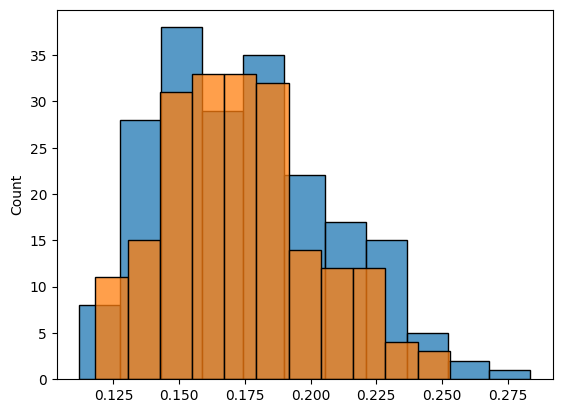

In [79]:
sns.histplot(licit_scores)
sns.histplot(illicit_scores)


In [84]:
thr = 0.16
(licit_scores > thr).sum() / len(licit_scores), (illicit_scores > thr).sum() / len(illicit_scores)

(0.625, 0.62)